# Integrated Project #1: Video Game

The goal of this project is to:

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import re, math

## Project Description

You work for the online store Ice, which sells video games all over the world. User and expert reviews, genres, platforms (e.g. Xbox or PlayStation), and historical data on game sales are available from open sources. You need to identify patterns that determine whether a game succeeds or not. This will allow you to spot potential big winners and plan advertising campaigns.

In front of you is data going back to 2016. Let’s imagine that it’s December 2016 and you’re planning a campaign for 2017.

(The important thing is to get experience working with data. It doesn't really matter whether you're forecasting 2017 sales based on data from 2016 or 2027 sales based on data from 2026.)

The dataset contains the abbreviation ESRB. The Entertainment Software Rating Board evaluates a game's content and assigns an age rating such as Teen or Mature.

## Table of Contents

- [The Goal](#goal)
- [Step 0](#imports): Imports
- [Step 1](#step1): Open the data file and study the general information
    - [Step 1 conclusion](#step1con)
- [Step 2](#step2): Prepare the data
    - [Names](#step2name)
    - [Year of Release](#step2year)
    - [Sales](#step2sales)
    - [Score](#step2scores)
    - [Ratings](#step2ratings)
    - [Step 2 conclusion](#step2con)
- [Step 3](#step3): Analyze the data
    - [Step 3 conclusion](#step3con)
- [Step 4](#step4): Analyze the data
    - [Step 4 conclusion](#step4con)
- [Step 5](#step5): Test the hypotheses
    - [Hypothesis 1](#step5h1): The average revenue from users of Ultimate and Surf calling plans differs
    - [Hypothesis 2](#step5h2): The average revenue from users in NY-NJ area is different from that of the users from other regions
    - [Step 5 conclusion](#step5con)
- [Step 6](#step6): Write an overall conclusion

### Step 1. Open the data file and study the general information
<a id='step1'></a>

In [2]:
raw_games_data = pd.read_csv('/datasets/games.csv')
games_data = raw_games_data
games_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


#### Step 1 conclusion
<a id='step1con'></a>

We do have some nulls, and in some columns, such as the Ratings, there are a lot. To work with the information, we will need to replace the column names with lowercase text, and acknowledge the following issues:

Name:
- There are two nulls, and in the information, they are also lacking genres, critic/user scores, and an ESRB rating. Because there are only 2 of 16715 entries, these should be removed.

Year_of_Release:
- We need to fill in the nulls. Some of the sports games have the year in the name (for example, 'Madden NFL 2004') so we will try to utilize those. Then we will try to fill in games with multiple platforms, but the year is only missing from one of the platforms. Otherwise, we will fill based on the mode.
- We need to change the types of this column to integers.

Genre:
- The only nulls are from the same two nulls mentioned in the Name column. so these will be taken care of as well.

Sales:
- The sales has a significant amount of zeros. These may be the result of consoles not sold in some countries, or the game itself not being sold in some countries. We would want to look at this further to see if something is going on here. Specifically for the Other sales, this seems to be the lowest category of purchasers of video games, and the zero seems to be more of an acceptable amount here.

Scores:
- Scores have a large amount of missing data. This will need to be filled in, most likely with averages based on the copies sold. Popular games that sell well will likely be higher rated.
- Critic score will need to be changed to an integer as it is a 0 to 100 score, and the user score will need to be changed to a float. 
- TBDs in the user score column oddly seem related games that are based off of movies/TV and brands. This may be an issue related to 

Rating:
 - ESRB rating also has a significant number of missing values. We will likely need to figure out the most common with the mode. Some are more intuitive than others, such as shooters would tend to be more M for Mature.

### Step 2. Prepare the data
<a id='step2'></a>

First for the entire dataset, we will need to replace the column names with lowercase text.

In [3]:
games_data.columns = [x.lower() for x in games_data.columns]

#### Name
<a id='step2name'></a>

The two nulls of the set may just be failures in the data gather process, as the name of the game is the principle identifier. Because there are only 2 of 16715 entries, these should be removed.

In [4]:
games_data.drop(games_data[games_data['name'].isnull()].index, inplace=True)

#### Year of Release
<a id='step2year'></a>

The years may be missing because this data seems focused on sales. The data may not prioritize the year then. 

First, we can attempt to draw information directly from the title. Some of the sports games, such as 'Madden NFL 2004' have the year in the name.

In [5]:
check_years = games_data.query('year_of_release.isnull()')
for i, row in check_years.iterrows():
    try:
        year = int(x = re.findall("[0-9][0-9][0-9][0-9]", row['name']))
    except:
        continue
    games_data.loc[i, 'year_of_release'] = year

In [6]:
check_years = games_data.query('year_of_release.isnull()')
for i, row in check_years.iterrows():
    try:
        year = int(row['name'][-2:])
    except:
        continue
    if year > 80:
        year += 1900
    elif year < 20:
        year += 2000
    else:
        continue
    games_data.loc[i, 'year_of_release'] = year

After that, we can try to see if some years are missing, but the same game but for a different platform has the year.

In [7]:
check_years = games_data.query('year_of_release.isnull()')
check_against = games_data.query('year_of_release.notnull()')

In [8]:
for i, row in check_years.iterrows():
    name = row['name']
    multiplatform = check_against.query('name == @name')
    if len(multiplatform):
        year = list(multiplatform['year_of_release'])[0]
        games_data.loc[i, 'year_of_release'] = year

Anything left over we can fill by using the mode based on the platform. As platforms are done in generations, they typically are popular for only a few consecutive years until the next console is released. Therefore, it should be fine to use the mode.

In [9]:
check_years = games_data.query('year_of_release.isnull()')
check_against = games_data.query('year_of_release.notnull()')

keys = check_against.platform.unique()
values = list(check_against.groupby('platform')['year_of_release'].agg(pd.Series.mode))
reference = {keys[i]: values[i] for i in range(len(keys))}

for i,val in check_years.platform.iteritems():
    replace  = reference[val]
    if not isinstance(replace, float):
        replace = replace[0]
    games_data.loc[i,'year_of_release'] = replace

Lastly, because they are years, we need to change them to integers.

In [10]:
games_data['year_of_release'] = pd.to_numeric(games_data['year_of_release'], downcast='integer')

#### Sales
<a id='step2sales'></a>

Lets take a look at the sales by platform.

In [11]:
check = games_data[['platform', 'na_sales', 'eu_sales', 'jp_sales']]
values = check.groupby('platform').mean()
print(values)

          na_sales  eu_sales  jp_sales
platform                              
2600      0.681203  0.041128  0.000000
3DO       0.000000  0.000000  0.033333
3DS       0.160558  0.118231  0.193596
DC        0.104423  0.032500  0.164615
DS        0.177778  0.087815  0.081623
GB        1.166531  0.487959  0.868571
GBA       0.228151  0.091545  0.057579
GC        0.240036  0.069622  0.038813
GEN       0.713704  0.204444  0.098889
GG        0.000000  0.000000  0.040000
N64       0.435799  0.128715  0.107273
NES       1.285102  0.215816  1.006633
NG        0.000000  0.000000  0.120000
PC        0.097053  0.146242  0.000175
PCFX      0.000000  0.000000  0.030000
PS        0.281136  0.178454  0.116809
PS2       0.270171  0.157006  0.064415
PS3       0.295635  0.248152  0.060248
PS4       0.277398  0.359923  0.040714
PSP       0.090298  0.055153  0.063507
PSV       0.029256  0.030512  0.050953
SAT       0.004162  0.003121  0.186474
SCD       0.166667  0.060000  0.075000
SNES      0.256192  0.079

Initially the zeros look like problems with our data, but after some research, it appears that these represent a lack of console based sales. For example, the Atari 2600 shows zero sales for Japan, but the Atari 2600 was not sold in Japan. Instead, a console labelled the Atari 2800 was. Similarly, the Game Gear (Presumably the GG item) was a Japanese based handheld console, which is why there are zero sales in NA and EU.

We would like to use the total sales later on, so we should add a global sales column.

In [12]:
games_data.insert(loc=8, column='total_sales', value=0.0)
for i, row in games_data.iterrows():
    games_data.loc[i,'total_sales'] = row['na_sales'] + row['eu_sales'] + row['jp_sales'] + row['other_sales']
games_data.sort_values(['total_sales'], ascending=False)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,total_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,82.54,76.0,8,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,35.52,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,32.77,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,31.38,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
16181,Sakura Sakura: Haru Urara,PSP,2010,Adventure,0.00,0.00,0.01,0.00,0.01,NaN,NaN,NaN
16182,Rocksmith 2014 Edition Remastered,XOne,2016,Misc,0.01,0.00,0.00,0.00,0.01,NaN,tbd,T
16714,Winning Post 8 2016,PSV,2016,Simulation,0.00,0.00,0.01,0.00,0.01,NaN,NaN,NaN
16676,G1 Jockey 4 2008,PS3,2008,Sports,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN


#### Scores
<a id='step2scores'></a>

Similar to the years, the scores may not be prioritized in the origination of the data. Because the scores have a lot of missing data, filling directly by an average may significantly weight the data and give biased results. We want to localize the information so we will get rolling averages by genre and total sales. Theoretically, the community of gamers likely are based on genre, so gamers interested in racing games would likely pick up more racing games and have a better understanding of what makes a racing game good or bad. Similarly, better scoring games should get better traction in sales, so that will be the other factor.

First we will start with the critic scores.

In [13]:
check = games_data.sort_values(['genre', 'total_sales'], ascending=(True, False))
check_critic_null = check.query('critic_score.isnull()')
for i, row in check_critic_null.iterrows():
    up, down, new_val = 1, 1, np.nan
    genre = row['genre']
    try:
        while pd.isna(check.loc[i-up, 'critic_score']):
            if check.loc[i-up, 'genre'] != genre:
                up = -1
                break
            up += 1
    except:
        up=-1
    
    try:
        while pd.isna(check.loc[i+down, 'critic_score']):
            if check.loc[i+down, 'genre'] != genre:
                down = -1
                break
            down += 1
    except:
        down=-1
    
    if up != -1 and down != -1:
        new_val = int((check.loc[i-up, 'critic_score'] + check.loc[i+down, 'critic_score'])/2)
    elif up != -1:
        new_val = check.loc[i-up, 'critic_score']
    elif down != -1:
        new_val = check.loc[i+down, 'critic_score']
    elif pd.notna(check.loc[i, 'user_score']) and check.loc[i, 'user_score'] != 'tbd':
        new_val = int(float(check.loc[i, 'user_score'])*10)
    
    games_data.loc[i, 'critic_score'] = new_val
games_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 12 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16713 non-null int16
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
total_sales        16713 non-null float64
critic_score       14354 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
dtypes: float64(6), int16(1), object(5)
memory usage: 2.2+ MB


Left over NaN values should be because there are no genre specific scores. This is certainly possible with the amount of missing values. Now we should try to base it on the total sales and not have it genre specific. Lastly, if there are still values left, we should use the user value to determine the critic value.

In [14]:
check = games_data.sort_values(['total_sales'], ascending=False)
check_critic_null = check.query('critic_score.isnull()')
for i, row in check_critic_null.iterrows():
    up, down, new_val = 1, 1, np.nan
    try:
        while pd.isna(check.loc[i-up, 'critic_score']):
            up += 1
    except:
        up=-1
    
    try:
        while pd.isna(check.loc[i+down, 'critic_score']):
            down += 1
    except:
        down=-1
    
    if up != -1 and down != -1:
        new_val = int((check.loc[i-up, 'critic_score'] + check.loc[i+down, 'critic_score'])/2)
    elif up != -1:
        new_val = check.loc[i-up, 'critic_score']
    elif down != -1:
        new_val = check.loc[i+down, 'critic_score']
    elif pd.notna(check.loc[i, 'user_score']) and check.loc[i, 'user_score'] != 'tbd':
        new_val = int(float(check.loc[i, 'user_score'])*10)
    if new_val != np.nan:
        games_data.loc[i, 'critic_score'] = new_val
games_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 12 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16713 non-null int16
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
total_sales        16713 non-null float64
critic_score       16713 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
dtypes: float64(6), int16(1), object(5)
memory usage: 2.2+ MB


Now we can repeat the same process with user scores. In user scores, there are TBD values. These values are most likely due to the sample size requirements of the score. Looking at the data, a majority of the TBD values appear to be on low selling games, and therefore are 'waiting' for a certain number of user scores to determine it is an acceptable sized survey. We can treat these the same as if they were NaN values.

In [15]:
check_user_null = check.query('user_score.isnull()')

for i, row in check_user_null.iterrows():
    up, down, new_val = 1, 1, -1
    genre = row['genre']
    
    try:
        while pd.isna(check.loc[i-up, 'user_score']) or check.loc[i-up, 'user_score'] == 'tbd':
            if check.loc[i-up, 'genre'] != genre:
                up = -1
                break
            up += 1
    except:
        up=-1
    
    try:
        while pd.isna(check.loc[i+down, 'user_score']) or check.loc[i+down, 'user_score'] == 'tbd':
            if check.loc[i+down, 'genre'] != genre:
                down = -1
                break
            down += 1
    except:
        down=-1

    if up != -1 and down != -1:
        new_val = (float(check.loc[i-up, 'user_score']) + float(check.loc[i+down, 'user_score']))/2
    elif up != -1:
        new_val = check.loc[i-up, 'user_score']
    elif down != -1:
        new_val = check.loc[i+down, 'user_score']
    if new_val != -1:
        games_data.loc[i, 'user_score'] = round(float(new_val),1)
games_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 12 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16713 non-null int16
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
total_sales        16713 non-null float64
critic_score       16713 non-null float64
user_score         14426 non-null object
rating             9949 non-null object
dtypes: float64(6), int16(1), object(5)
memory usage: 2.2+ MB


In [16]:
for i, row in games_data.iterrows():
    if row['user_score'] == 'tbd' or row['user_score'] is np.nan:
        games_data.loc[i, 'user_score'] = round(row['critic_score']/10, 1)

The critic score are integers on a scale from 1 to 100, and the user scores are floats from 0.0 to 10.0, so we need to cast them as such.

In [17]:
games_data['critic_score'] = pd.to_numeric(games_data['critic_score'], downcast='integer')
games_data['user_score'] = pd.to_numeric(games_data['user_score'], downcast='float')
games_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 12 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16713 non-null int16
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
total_sales        16713 non-null float64
critic_score       16713 non-null int8
user_score         16713 non-null float32
rating             9949 non-null object
dtypes: float32(1), float64(5), int16(1), int8(1), object(4)
memory usage: 2.0+ MB


#### Ratings
<a id='step2ratings'></a>

In [18]:
check_rating = games_data.query('rating.isnull()')
check_against = games_data.query('rating.notnull()')

In [19]:
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

In [20]:
check_against['keys'] = check_against.platform+"."+check_against.genre
keys = list(check_against['keys'].unique())

In [21]:
values = list(check_against.groupby(['platform', 'genre'])['rating'].agg(pd.Series.mode))
print(check_against.groupby(['platform', 'genre'])['rating'].agg(pd.Series.mode))
reference = {keys[i]: values[i] for i in range(len(values))}

for i,row in check_rating.iterrows():
    check = row.platform + "." + row.genre
    try:
        replace  = reference[check]
        games_data.loc[i,'rating'] = replace
    except:
        continue

platform  genre       
3DS       Action            E10+
          Adventure         E10+
          Fighting             T
          Misc                 E
          Platform             E
                           ...  
XOne      Role-Playing         M
          Shooter              M
          Simulation      [E, T]
          Sports               E
          Strategy        [E, T]
Name: rating, Length: 198, dtype: object


In [22]:
check_rating = games_data.query('rating.isnull()')
check_against = games_data.query('rating.notnull()')

In [23]:
check_rating_null = games_data.query('rating.isnull()')
for i, row in check_critic_null.iterrows():
    up, down, new_val = 1, 1, np.nan
    try:
        while pd.isna(games_data.loc[i-up, 'rating']):
            up += 1
    except:
        up=-1
    
    try:
        while pd.isna(games_data.loc[i+down, 'rating']):
            down += 1
    except:
        down=-1
    
    if up != -1 and down != -1:
        if up < down:
            new_val = games_data.loc[i-up, 'rating']
        else:
            new_val = games_data.loc[i+down, 'rating']
    elif up != -1:
        new_val = games_data.loc[i-up, 'rating']
    elif down != -1:
        new_val = games_data.loc[i+down, 'rating']
    else:
        genre = row['genre']
        new_val = games_data.groupby(['genre'])['rating'].agg(pd.Series.mode).loc[genre]
    games_data.loc[i, 'rating'] = new_val
games_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 12 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16713 non-null int16
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
total_sales        16713 non-null float64
critic_score       16713 non-null int8
user_score         16713 non-null float32
rating             15855 non-null object
dtypes: float32(1), float64(5), int16(1), int8(1), object(4)
memory usage: 2.0+ MB


In [24]:
keys = check_against.genre.unique()
values = list(check_against.groupby(['genre'])['rating'].agg(pd.Series.mode))
reference = {keys[i]: values[i] for i in range(len(values))}

for i,row in check_rating.iterrows():
    check = row.genre
    try:
        replace  = reference[check]
        games_data.loc[i,'rating'] = replace
    except:
        continue

In [25]:
games_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 12 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16713 non-null int16
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
total_sales        16713 non-null float64
critic_score       16713 non-null int8
user_score         16713 non-null float32
rating             16713 non-null object
dtypes: float32(1), float64(5), int16(1), int8(1), object(4)
memory usage: 2.0+ MB


Lastly, it turns out that K-A was a rating that is the same as E, as K-A is kids through adults, and was later changed to mean E. We should change that in this data as well.

In [26]:
games_data.loc[games_data['rating'] == "K-A", "rating"] = "E"

In [27]:
games_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 12 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16713 non-null int16
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
total_sales        16713 non-null float64
critic_score       16713 non-null int8
user_score         16713 non-null float32
rating             16713 non-null object
dtypes: float32(1), float64(5), int16(1), int8(1), object(4)
memory usage: 2.0+ MB


All of the ratings are now filled in.

#### Step 2 Conclusion
<a id='step2con'></a>

 All of the data has been cleaned and filled in. There are no longer any missing values, and there are no more obtuse values such as TBD. All of the characteristics are their correct types, and are adequately downsized to optimized types.

### Step 3. Analyze the data
<a id='step3'></a>

- Look at how many games were released in different years. Is the data for every period significant?
- Look at how sales varied from platform to platform. Choose the platforms with the greatest total sales and build a distribution based on data for each year. Find platforms that used to be popular but now have zero sales. How long does it generally take for new platforms to appear and old ones to fade?
- Determine what period you should take data for. To do so, look at your answers to the previous questions. The data should allow you to build a prognosis for 2017.
- Work only with the data that you've decided is relevant. Disregard the data for previous years.
- Which platforms are leading in sales? Which ones are growing or shrinking? Select several potentially profitable platforms.
- Build a box plot for the global sales of all games, broken down by platform. Are the differences in sales significant? What about average sales on various platforms? Describe your findings.
- Take a look at how user and professional reviews affect sales for one popular platform (you choose). Build a scatter plot and calculate the correlation between reviews and sales. Draw conclusions.
- Keeping your conclusions in mind, compare the sales of the same games on other platforms.
- Take a look at the general distribution of games by genre. What can we say about the most profitable genres? Can you generalize about genres with high and low sales?

First lets look at the total sales by release year.

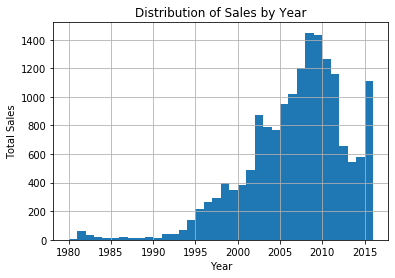

In [28]:
total_years = games_data.year_of_release.max()-games_data.year_of_release.min()
games_data.year_of_release.hist(bins=total_years)

plt.ylabel('Total Sales')
plt.xlabel('Year')
plt.title('Distribution of Sales by Year')
plt.show()

There appears to be an early tail, most likely when gaming had not yet fully joined the ranks of pop culture that we know it has today. This delay is likely due to consumer access and early technology. 

It can be compared to the cell phone we know today. It used to be a large brick that had a large price tag of nearly //$4,000 and was extremely limited battery life of about 30 minutes, as mentioned by [this NBC article](https://www.nbcnews.com/id/wbna7432915).

This was not seen as something really necessary for anyone but wealthy business leaders. Soon, technology became cheaper and now most citizens of developed countries have a cell phone.

That being said, lets remove this time period needed for gaming to take off. 

In [29]:
q1 = games_data.year_of_release.quantile(q=.25)
q3 = games_data.year_of_release.quantile(q=.75)
IQR = q3-q1
games_data = games_data.query('year_of_release > @q1 - @IQR*1.5')

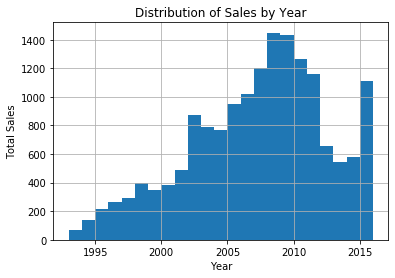

In [30]:
total_years = games_data.year_of_release.max()-games_data.year_of_release.min()
games_data.year_of_release.hist(bins=total_years)

plt.ylabel('Total Sales')
plt.xlabel('Year')
plt.title('Distribution of Sales by Year')
plt.show()

Now lets try to filter out the less popular platforms. Also, as we are trying to predict near future results, we need to make sure that the consoles are still selling games in the most recent year. Otherwise, they will not be selling games in 2017 either.

In [31]:
grouped_platform_sales = games_data.groupby(['platform', 'year_of_release'])['total_sales'].agg(['sum', 'count'])

In [32]:
plats = []
for platform, df in grouped_platform_sales.groupby(level=0):
    #print(df.index)
    keep = df.index.isin(['2016'], level='year_of_release')
    #print(df)
    if 1 in keep:
        plats.append(platform)
print(plats)

['3DS', 'PC', 'PS3', 'PS4', 'PSV', 'Wii', 'WiiU', 'X360', 'XOne']


To understand each platform's performance, we need to calculate the total number of sales per year, per platform.

In [33]:
usable_platforms = grouped_platform_sales[grouped_platform_sales.index.get_level_values('platform').isin(plats)]
print(usable_platforms)
clean_games_data = games_data.query('platform.isin(@plats)')

                            sum  count
platform year_of_release              
3DS      1993              0.40      1
         1999              0.47      5
         2000              0.02      1
         2010              0.30      1
         2011             63.20    116
...                         ...    ...
X360     2016              1.52     13
XOne     2013             18.96     19
         2014             54.07     61
         2015             60.14     80
         2016             26.15     87

[101 rows x 2 columns]


There are a few games that are highly skewing the results, such as Wii Sports, that may be diamonds in the rough, and can not be used to predict future sales.

In [34]:
q1 = clean_games_data.total_sales.quantile(q=.25)
q3 = clean_games_data.total_sales.quantile(q=.75)
IQR = q3-q1
filtered_clean_games_data = clean_games_data.query('total_sales < @q3 + @IQR*1.5')
total_years = clean_games_data.year_of_release.max()-clean_games_data.year_of_release.min()
plat_count = clean_games_data.pivot_table(values= 'total_sales', index='year_of_release', columns='platform', aggfunc='sum', fill_value=0)
filtered_plat_count = filtered_clean_games_data.pivot_table(values= 'total_sales', index='year_of_release', columns='platform', aggfunc='sum', fill_value=0)

In [35]:
# This is to make sure that colors are different with a large number of different colored bars in our graphs
def floatRgb(mag, cmin, cmax):
    """ Return a tuple of floats between 0 and 1 for R, G, and B. """
    # Normalize to 0-1
    try: x = float(mag-cmin)/(cmax-cmin)
    except ZeroDivisionError: x = 0.5 # cmax == cmin
    blue  = min((max((4*(0.75-x), 0.)), 1.))
    red   = min((max((4*(x-0.25), 0.)), 1.))
    green = min((max((4*math.fabs(x-0.5)-1., 0.)), 1.))
    return red, green, blue

def rgb(mag, cmin, cmax):
    """ Return a tuple of integers, as used in AWT/Java plots. """
    red, green, blue = floatRgb(mag, cmin, cmax)
    return int(red*255), int(green*255), int(blue*255)

def strRgb(mag, cmin, cmax):
    """ Return a hex string, as used in Tk plots. """
    return "#%02x%02x%02x" % rgb(mag, cmin, cmax)

['Wii' 'X360' 'PS3' 'PS4' '3DS' 'PC' 'XOne' 'WiiU' 'PSV']
['PC' 'Wii' 'PS3' 'XOne' 'X360' 'WiiU' '3DS' 'PS4' 'PSV']


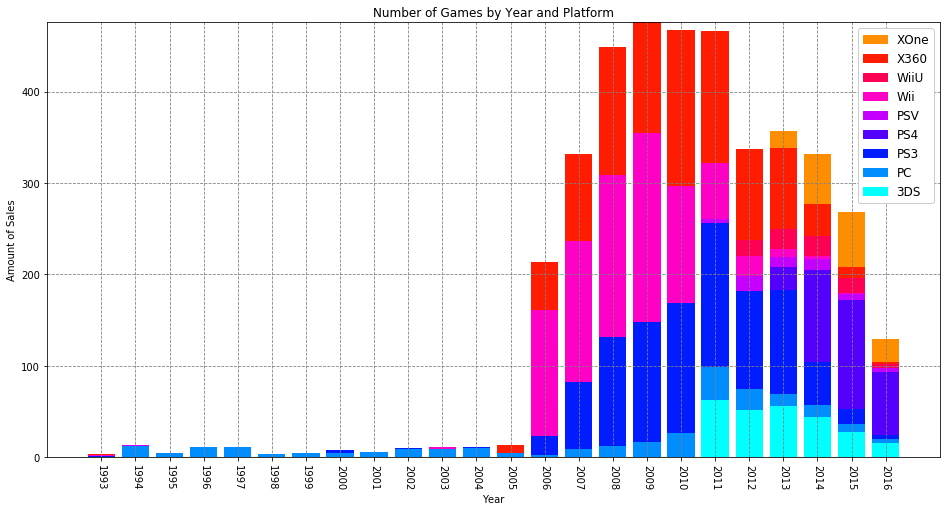

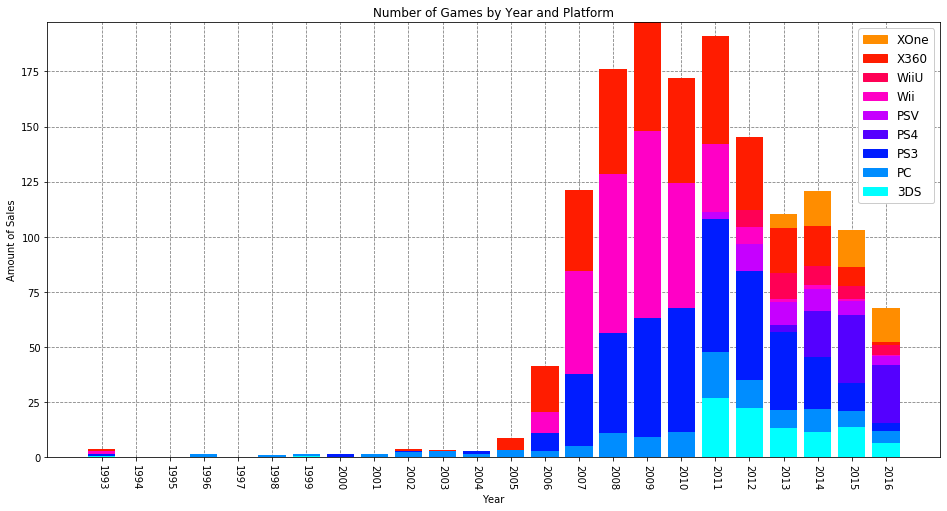

In [36]:
# Plotting
plots = [clean_games_data, filtered_clean_games_data]
plot_totals = [plat_count, filtered_plat_count]

for plot in range(len(plots)):
    plt.figure(figsize=(16,8))
    print(plots[plot].platform.unique())
    color_vals = []
    #rotates through the platforms
    for i in range(len(plots[plot].platform.unique())):
        num = i*1/len(plots[plot].platform.unique())
        color = strRgb(num,0,1)
        color_vals.append(color)

    # Creating dictionaries with colors
    colors = {i: color_vals[i] for i in range(len(color_vals))}
    vals = list(plots[plot].platform.unique())
    platforms = {i: vals[i] for i in range(len(vals))}

    # Plotting in a loop
    for i in range(len(plot_totals[plot].index)):
        year = plot_totals[plot].index[i]
        year_data = plot_totals[plot].loc[year]
        baseline = 0
        color_index = 0
        for j in year_data:
            plt.bar(x = i, height = j, bottom = baseline, color=colors[color_index])
            baseline += j
            color_index += 1

    plt.xticks(np.arange(len(plot_totals[plot].index)), plot_totals[plot].index, rotation = 270);

    # Creating legend
    patches = list()
    for i in reversed(range(len(plots[plot].platform.unique()))):
        patch = mpatches.Patch(color = colors[i], label = plot_totals[plot].columns[i])
        patches.append(patch)
    plt.legend(handles=patches, fontsize=12, framealpha=1)

    # Some additioanl plot prep
    plt.rcParams['axes.axisbelow'] = True
    plt.grid(color='gray', linestyle='dashed')
    plt.ylabel('Amount of Sales')
    plt.xlabel('Year')
    plt.title('Number of Games by Year and Platform');

<div class="alert alert-success" role="alert">
Reviewer's comment v. 1:
    
AN excellent graphs, but Ridgeplots can be useful here: https://matplotlib.org/matplotblog/posts/create-ridgeplots-in-matplotlib/ 
</div>

We can see a large boost of games sold around 2009 through 2011, primarily for the success of the Wii, PS3, and Xbox 360 consoles. After that burst, the sales drop, and then next gen consoles become popular, but not at the same level and are already falling well below previous years by 2016.

To make a prediction for the next year, we need to attempt a parabolic trend, as it will be based on the growth or decay of the popularity of the platforms, and it should also represent how quickly the platforms are coming in and out of popularity. 

We can see in the above plots on a single platform basis that there are parabolic trends where there is not enough time yet for game developers to create games for a brand new platform, they get that time to make it, and over time the platform becomes outdated, and developers and consumers both prepare for the new consoles. In particular, consumers may want to save money on video games if they believe a platform is nearing the end of its stride, and would want to be financially ready for the next platform. 

This parabolic trend tends to line up for platforms, as major competing consoles launch at the same time. For example, the playstation series from Sony typically launches around the same time as Microsoft's Xbox line to drive sales with competition.

In [37]:
predicting_2017 = filtered_clean_games_data.query('year_of_release.isin([2014, 2015, 2016])')
temp = pd.pivot_table(predicting_2017, values='total_sales', index='platform', columns='year_of_release', aggfunc='sum')

In [38]:
def calc_parabola_vertex(x1, y1, x2, y2, x3, y3):

    denom = (x1-x2) * (x1-x3) * (x2-x3);
    A     = (x3 * (y2-y1) + x2 * (y1-y3) + x1 * (y3-y2)) / denom;
    B     = (x3*x3 * (y1-y2) + x2*x2 * (y3-y1) + x1*x1 * (y2-y3)) / denom;
    C     = (x2 * x3 * (x2-x3) * y1+x3 * x1 * (x3-x1) * y2+x1 * x2 * (x1-x2) * y3) / denom;

    return A,B,C

In [39]:
for i, row in temp.iterrows():
    x1, y1 = [2014, row[2014]]
    x2, y2 = [2015, row[2015]]
    x3, y3 = [2016, row[2016]]
    
    a, b, c = calc_parabola_vertex(x1, y1, x2, y2, x3, y3)
    new_val=(a*(2017**2))+(b*2017)+c
    
    if new_val > 0:
        temp.loc[i, 2017] = new_val
    else:
        temp.loc[i, 2017] = 0
temp

year_of_release,2014,2015,2016,2017
platform,,,,
3DS,11.47,13.86,6.67,0.000000
PC,10.23,7.24,5.25,4.260001
PS3,23.85,12.43,3.60,0.000000
PS4,20.98,31.08,26.39,6.910005
PSV,9.94,6.25,4.25,3.940000
Wii,1.74,1.14,0.18,0.000000
WiiU,8.54,5.82,4.60,4.880000
X360,18.06,8.69,1.52,0.000000
XOne,16.09,16.54,15.32,12.430000


Now that we have the estimated amounts of sales per platform, we need to integrate it into our sales graph.

In [40]:
filtered_plat_count = filtered_plat_count.append(temp[2017])
print(temp[2017].sum())

32.4200055571273


['PC' 'Wii' 'PS3' 'XOne' 'X360' 'WiiU' '3DS' 'PS4' 'PSV']


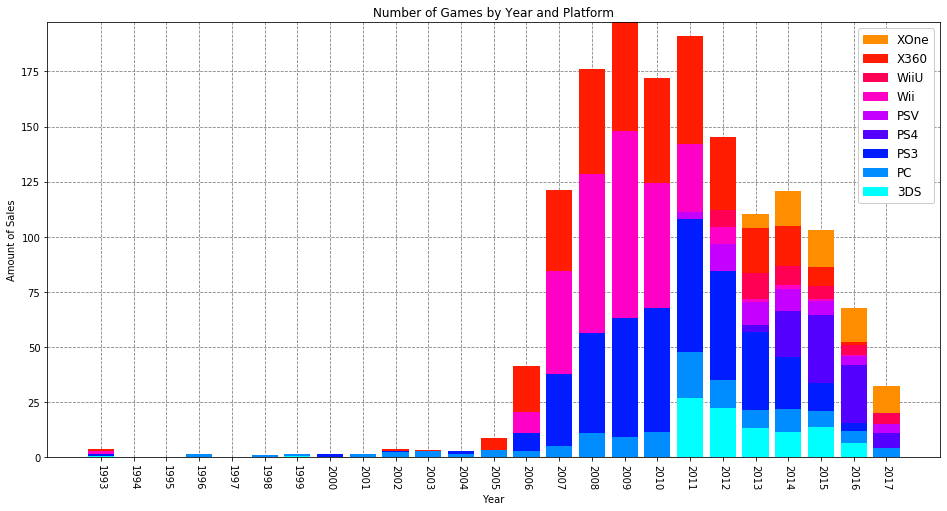

In [41]:
# Plotting
plots = [filtered_clean_games_data]
plot_totals = [filtered_plat_count]

for plot in range(len(plots)):
    plt.figure(figsize=(16,8))
    print(plots[plot].platform.unique())
    color_vals = []
    for i in range(len(plots[plot].platform.unique())):
        num = i*1/len(plots[plot].platform.unique())
        color = strRgb(num,0,1)
        color_vals.append(color)

    # Creating dictionaries with colors and cancelaltion causes
    colors = {i: color_vals[i] for i in range(len(color_vals))}
    vals = list(plots[plot].platform.unique())
    platforms = {i: vals[i] for i in range(len(vals))}

    # Plotting in a loop
    for i in range(len(plot_totals[plot].index)):
        year = plot_totals[plot].index[i]
        year_data = plot_totals[plot].loc[year]
        baseline = 0
        color_index = 0
        for j in year_data:
            plt.bar(x = i, height = j, bottom = baseline, color=colors[color_index])
            baseline += j
            color_index += 1
        #plt.text(x = i, y = plat_count[i] + 0.05, s = round(plat_count[i], 1), \
                 #ha = 'center', fontsize=13)
#     for j in year_data:
#             plt.bar(x = 2017, height = j, bottom = baseline, color=colors[color_index])
#             baseline += j
#             color_index += 1
    

    plt.xticks(np.arange(len(plot_totals[plot].index)), plot_totals[plot].index, rotation = 270);

    # Creating legend
    patches = list()
    for i in reversed(range(len(plots[plot].platform.unique()))):
        patch = mpatches.Patch(color = colors[i], label = plot_totals[plot].columns[i])
        patches.append(patch)
    plt.legend(handles=patches, fontsize=12, framealpha=1)

    # Some additioanl plot prep
    plt.rcParams['axes.axisbelow'] = True
    plt.grid(color='gray', linestyle='dashed')
    plt.ylabel('Amount of Sales')
    plt.xlabel('Year')
    plt.title('Number of Games by Year and Platform');

We can see that from about 2013 to 2016, it has risen, and began dropping at a faster rate. Our prediction of 2017 at this level of modelling visibly follows that trend. One thing to note is that this indicates, from what we know of the gaming industry, that it would likely be time for a new generation of consoles to come out, restarting the wave of consumer sales.

Next, lets look at the distribution of these games by platform.

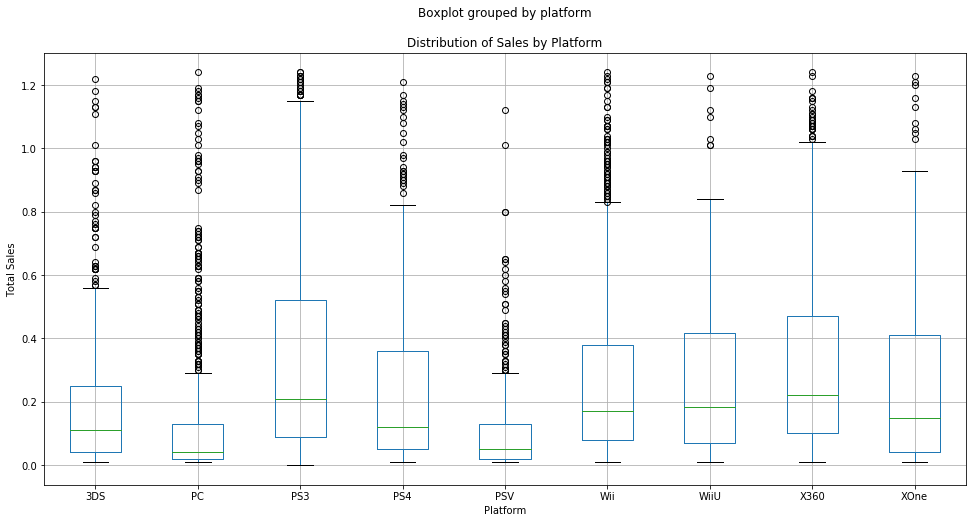

In [42]:
filtered_clean_games_data.boxplot(column='total_sales', by='platform', figsize=(16,8))
plt.ylabel('Total Sales')
plt.xlabel('Platform')
plt.title('Distribution of Sales by Platform')
plt.show()


It appears that there are a significant number of outliers accross the board. This shows, that a large portion of each platforms market performance is largely based on triple A titles, but there are still a significant number of games that are indie games, less advertised games, or games that just generally did not get the same amount of traction among consumers. 

It looks like overall, the PS3 and Xbox 360 generally had better selling games, as the distribution is spread out to higher sales. The PSV was not know for its popularity, so this explains is low distribution. As for the PC, it is known for having a lot of indie games, as it is more accessible for game makers to distribute games. This accessibility also explains the large number of outliers as well.

Now lets take a look at how critic and user reviews affect sales of a single platform. For this example, we will look at the Wii.

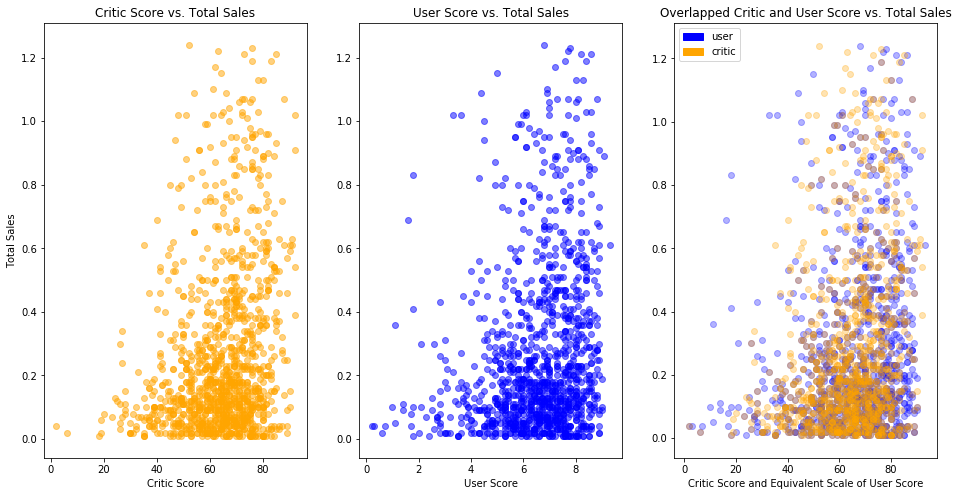

In [43]:
wii_data = filtered_clean_games_data[clean_games_data['platform'] == 'Wii']
fig, axes = plt.subplots(ncols=3, figsize=(16,8))

axes[0].scatter(wii_data.critic_score, wii_data.total_sales, color='orange', alpha=.5)
axes[1].scatter(wii_data.user_score, wii_data.total_sales, color='blue', alpha=.5)
axes[2].scatter(wii_data.user_score*10, wii_data.total_sales, color='blue', alpha=.3)
axes[2].scatter(wii_data.critic_score, wii_data.total_sales, color='orange', alpha=.3)

pop_a = mpatches.Patch(color='blue', label='user')
pop_b = mpatches.Patch(color='orange', label='critic')

axes[2].legend(handles=[pop_a,pop_b], loc='upper left')

axes[0].set(title='Critic Score vs. Total Sales', xlabel='Critic Score', ylabel='Total Sales')
axes[1].set(title='User Score vs. Total Sales', xlabel='User Score')
axes[2].set(title='Overlapped Critic and User Score vs. Total Sales', xlabel='Critic Score and Equivalent Scale of User Score')

plt.show()

Although critic and user reviews look similar, we can see that barring a few outliers, users tend to be more willing to rate games higher than critics. It also seems that the shape of the critics scoring appears to be more rectangular than the users score. This implies that the amount of sales has less of an impact on the scoring than users do. Users may be more inclined to be influenced by word of mouth and riding the wave of a game's popularity.

A lot of games are multiplatform, so lets see if there is much of a difference between platforms.

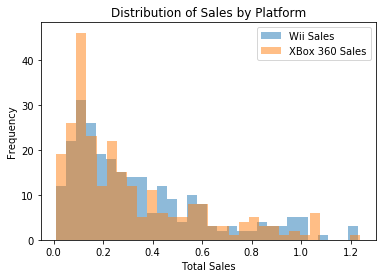

In [44]:
wii_data = wii_data[['name', 'na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'total_sales']]
x360_data = filtered_clean_games_data[clean_games_data['platform'] == 'X360']
x360_data = x360_data[['name', 'na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'total_sales']]
wii_x360_cross = pd.merge(wii_data, x360_data, on="name", suffixes=("Wii", "X360"))

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.hist(wii_x360_cross['total_salesWii'], bins=30, alpha= 0.5, label='Wii Sales')
ax1.hist(wii_x360_cross['total_salesX360'], bins=30, alpha= 0.5, label='XBox 360 Sales')
plt.legend(loc='upper right');
plt.ylabel('Frequency')
plt.xlabel('Total Sales')
plt.title('Distribution of Sales by Platform')
plt.show()

It does appear that there may be a slight bias towards Xbox 360. This does make some sense, as the consoles are very different. The Xbox is primarily a button input, while the wii does have button inputs, but the console was largely popular to it's motion control. Because the Xbox does not have motion controls, motion control games would not be multi platform, and so it does not have that advantage of what area of expertise gave it its popularity.

Now lets take a look into the same level of detail for the game genres.

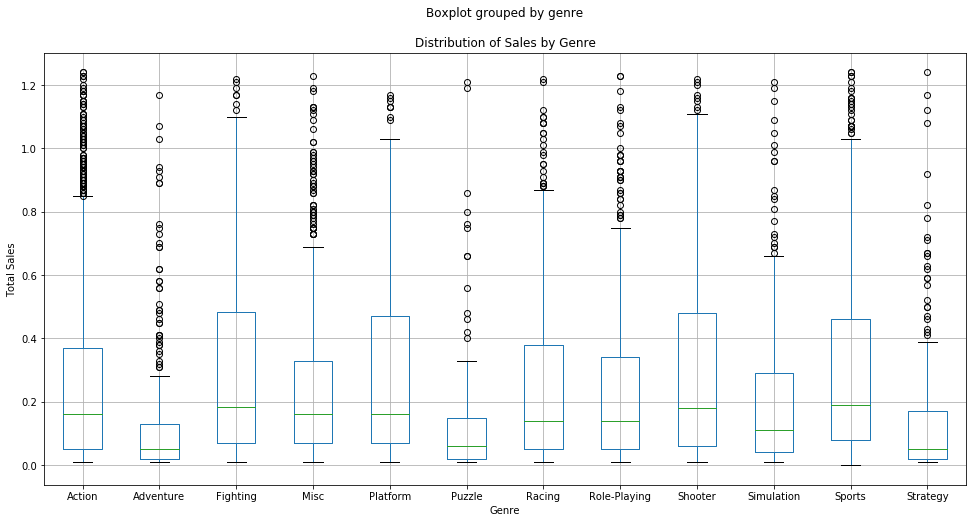

In [45]:
top_plats = filtered_clean_games_data.groupby('genre')['total_sales'].sum()
filtered_clean_games_data.boxplot(column='total_sales', by='genre', figsize=(16,8))
plt.ylabel('Total Sales')
plt.xlabel('Genre')
plt.title('Distribution of Sales by Genre')
plt.show()

The largest genres are Action, Fighting, Platform, Shooter, and Sports. This makes sense as they make up a large part of the triple A title games, including well established franchises such as Zelda, Mortal Combat, Mario, Call of Duty, and Fifa. The lowest are Adventure, Puzzle, and Strategy, games that are typical as indie titles and represent lower volume and pricing.

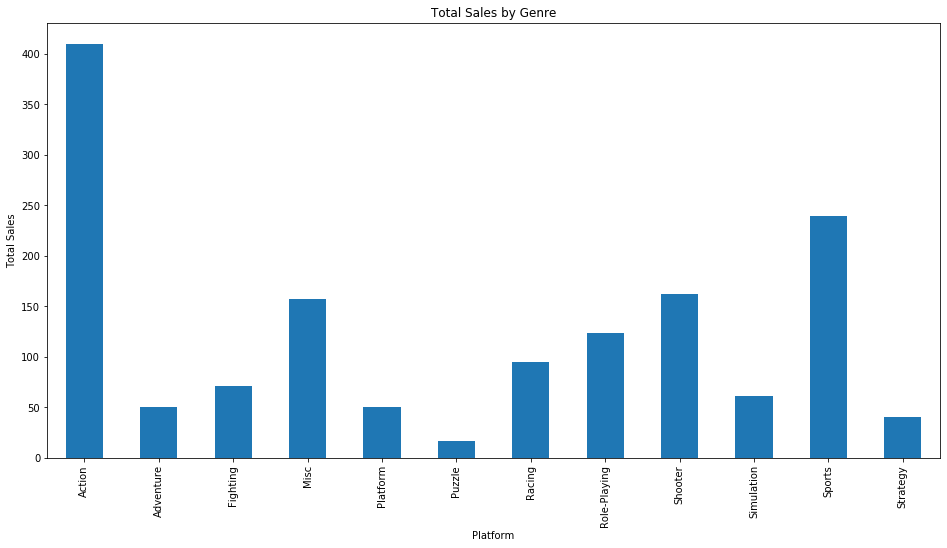

In [46]:
top_plats.plot('bar', figsize=(16,8))
plt.ylabel('Total Sales')
plt.xlabel('Platform')
plt.title('Total Sales by Genre')
plt.show()

Similarly to the distribution, the largest amount of sales are in Action and Sports, while the lower sales are in puzzle and strategy. The differences between these total amounts and the distribution is largely in the volume of games in the market place.

#### Step 3 Conclusion
<a id='step3con'></a>

After viewing the preliminary data, we saw that the earlier years are not very representative, so all lower outlying years were filtered out. We then filtered for the popular and relevant consoles, based on being more recently selling platforms. We saw a large boost of games sold around 2009 through 2011, primarily for the success of the Wii, PS3, and Xbox 360 consoles - at those years, they were relatively new. After that burst, the success fell, and then next gen consoles came out, but the wave was not as successful and are already falling well below by 2016. Because of this trend, and without the knowledge of new consoles, the trend naturally falls, and we expect sales around 32.4 million USD.

As expected with the waves of success, consoles such as the PS3 and Xbox 360 had higher distributions of sales, while handhelds and PC games sold typically lower. 

We also found that users and critics scored games very similar, but users may be slightly more biased by the traction in sales and popularity by word of mouth. Consoles were also relatively similar, but small discrepancies can be found between multiplatform games, and this may be due to the strengths and weaknesses of the consoles in relation to the game types. 

We also looked at the distribution of sales based on genre and noticed that more total sales by genre correlated with higher distribution of better selling games. They also are typically the genres of triple A games, so these distributions make sense.

### Step 4. Create a user profile for each region
<a id='step4'></a>

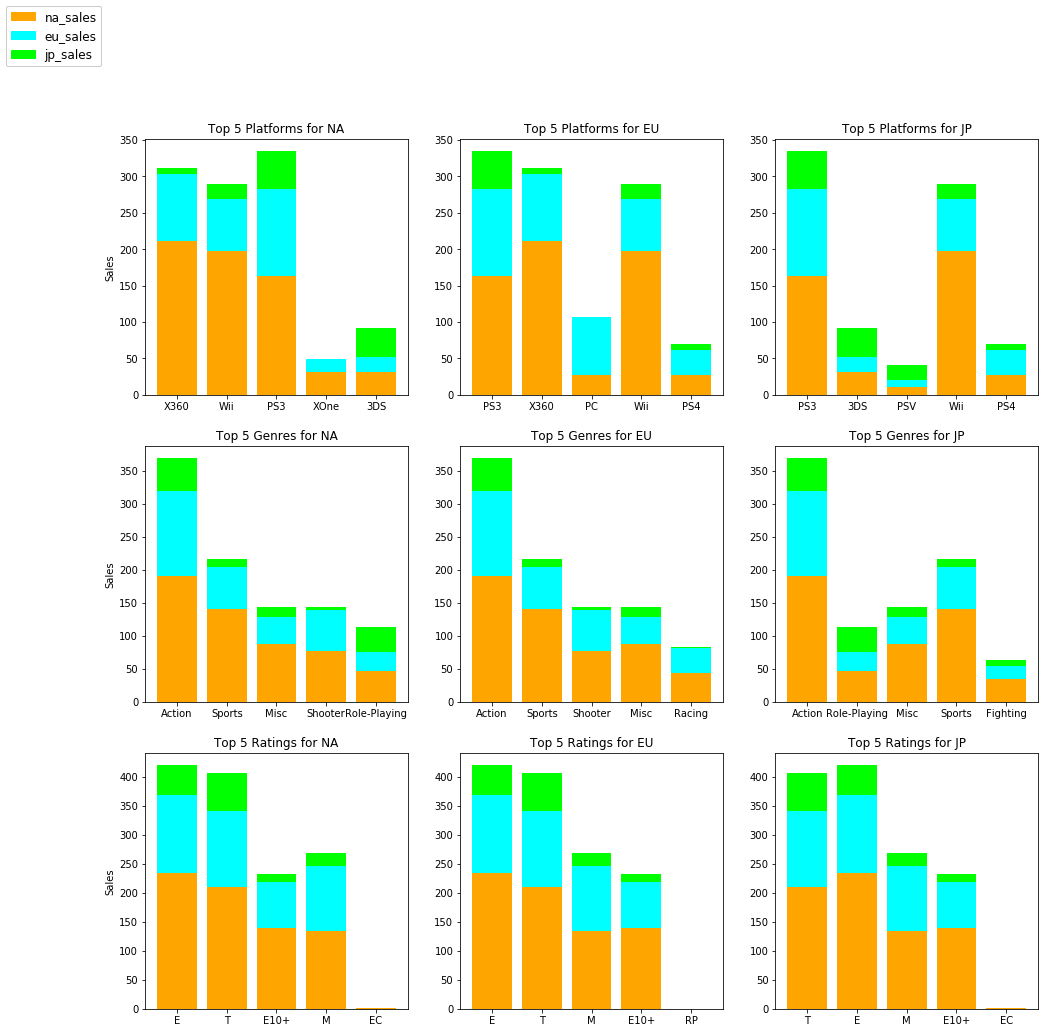

In [47]:
categories = ['platform', 'genre', 'rating']
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16,16))

color_vals = ['orange', 'cyan', 'lime']
colors = {i: color_vals[i] for i in range(len(color_vals))}
vals = ['na_sales', 'eu_sales', 'jp_sales']
locations = {i: vals[i] for i in range(len(vals))}

for i in range(len(categories)):
    top_order = filtered_clean_games_data.groupby(categories[i])['na_sales', 'eu_sales', 'jp_sales'].sum()
    na_top_order = top_order.sort_values(by='na_sales', ascending=False)
    eu_top_order = top_order.sort_values(by='eu_sales', ascending=False)
    jp_top_order = top_order.sort_values(by='jp_sales', ascending=False)
    top = [na_top_order, eu_top_order, jp_top_order]
    
    for j in range(len(top)):
        # Plotting in a loop
        for k in range(5):
            platforms = top[j].index[k]
            platforms_data = top[j].loc[platforms]
            baseline = 0
            color_index = 0
            for m in platforms_data:
                axes[i,j].bar(x = k, height = m, bottom = baseline, color=colors[color_index])
                baseline += m
                color_index += 1

        title_label = 'Top 5 ' + top_order.index.name.title() + 's for ' + top_order.columns[j][:2].upper()
        axes[i,j].set_title(label=title_label)
        axes[i,j].xaxis.set(ticks=np.arange(5), ticklabels=top[j].index)
        axes[i,0].set_ylabel(ylabel='Sales')
        
#Creating legend
patches = list()
for i in range(3):
    #patch = mpatches.Patch(color = colors[i], label = cancellation_cause[cancellation_code_per_carrier_pct.columns[i]])
    patch = mpatches.Patch(color = colors[i], label = top_order.columns[i])
    patches.append(patch)
fig.legend(handles=patches, fontsize=12, framealpha=1, loc='upper left')
fig.show()

#### Step 4 Conclusion
<a id='step4con'></a>

For the top 5 platforms by location, the Xbox 360, Wii, and PS3 were very popular in North America, but nothing outstanding byond those three. The EU is similar, but PC was preferenced over the Wii, keeping course with tactile, button based platforms. In Japan, PS3 was the largest platform, but handhelds were highly prefered over what was popular for both the EU and NA groups. This deiscrepancy may be largely due to [Japan's significantly higher use of public transport](https://en.wikipedia.org/wiki/List_of_countries_by_rail_usage). This means they may be more inclined to use that time on a train to use a handheld console for convenience. 

For the top 5 genres by location, Action and Sports were very the most popular in North America, and the EU. In Japan, Role-Playing was a close second, which was at the 5th spot in NA and was not even present in the EU's top 5. This may be due to the popularity with sports in the respective countries. For example, some of the two most successful sports games are the Madden NFL american football series and FIFA Soccer (european football) series. Both of these may correlate with the popularity of the sports in the United States and Europe respectively.

For the top 5 ratings by location, E and T were every groups first and second, respectively. In Japan and the EU, M took precedent over E10+, but the opposite was true in NA. The differences between M and E10+ however, are quite small in all regions, and may be considered negligible.

### Step 5. Test the following hypotheses:
<a id='step5'></a>

In [48]:
# the level of significance
alpha = .05

#### Average user ratings of the Xbox One and PC platforms are the same.
<a id='step5h1'></a>

A dual sample t-test will be used to determine if the _surf_ plan and _ultimate_ plan generate different monthly revenues per person. We will create the following hypotheses:

The null hypothesis, $H_0$: The average score from users of the Xbox One games and PC games are equal.  
The alternative hypothesis, $H_A$: The average score from users of the Xbox One games and PC games are not equal. 

In [49]:
set1 = filtered_clean_games_data[filtered_clean_games_data.platform == 'XOne']['user_score']
set2 = filtered_clean_games_data[filtered_clean_games_data.platform == 'PC']['user_score']

results = st.ttest_ind(
    filtered_clean_games_data[filtered_clean_games_data.platform == 'XOne']['user_score'],
    filtered_clean_games_data[filtered_clean_games_data.platform == 'PC']['user_score'],
    equal_var=False)

print('p-value: ', results.pvalue)

if results.pvalue > alpha:
    print('We cannot reject the null hypothesis')
else:
    print('We can reject the null hypothesis')

p-value:  0.001260648856892789
We can reject the null hypothesis


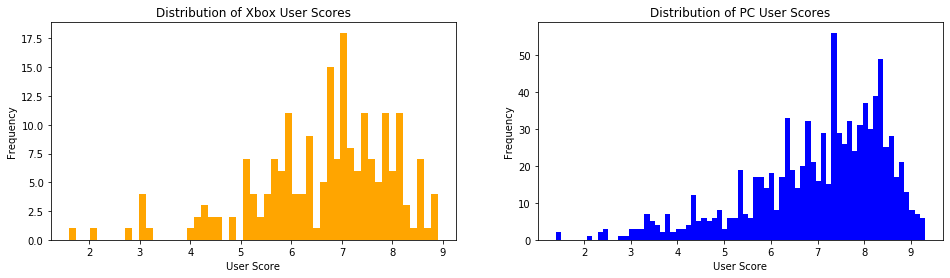

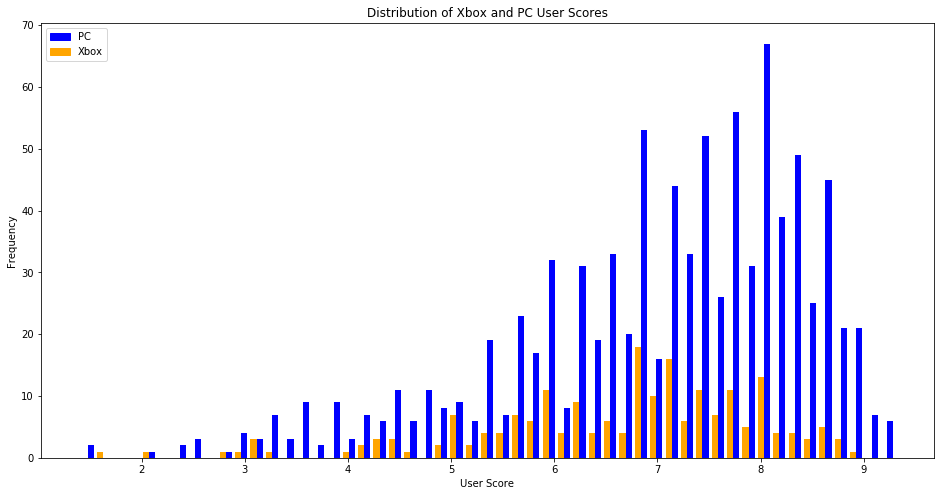

In [50]:
fig, axes = plt.subplots(ncols=2, figsize=(16,4))

xbox = filtered_clean_games_data[filtered_clean_games_data.platform == 'XOne']
pc = filtered_clean_games_data[filtered_clean_games_data.platform == 'PC']

axes[0].hist(xbox.user_score, bins=len(xbox.user_score.unique()), color='orange')
axes[1].hist(pc.user_score, bins=len(pc.user_score.unique()), color='blue')
axes[0].set(title='Distribution of Xbox User Scores', xlabel='User Score', ylabel='Frequency')
axes[1].set(title='Distribution of PC User Scores', xlabel='User Score', ylabel='Frequency')

plt.show()

pop_a = mpatches.Patch(color='blue', label='PC')
pop_b = mpatches.Patch(color='orange', label='Xbox')

fig, axes = plt.subplots(ncols=1, figsize=(16,8))
axes.hist([xbox.user_score, pc.user_score], bins=len(xbox.user_score.unique()), color=['orange', 'blue'])
axes.set(title='Distribution of Xbox and PC User Scores', xlabel='User Score', ylabel='Frequency')
axes.legend(handles=[pop_a,pop_b], loc='upper left')
plt.show()

To confirm, it does appear that the distribution of the PC user score is more left skewed than the Xbox user score. the PC scores peak around 6.7, and tail more evenly in both directions, while there seems to be a larger dostribution of high ranked PC games.

The variances of the two subsamples are not equal, and therefore the parameter, `equal_var` must be set to False to compare sets with different variances and/or sets of different sizes.

The null hypothesis of a dual sample t-test is that the two groups are similar, and the alternative hypothesis is that they are dissimilar. 

In this case, the null hypothesis is that the average score from users of the Xbox One games are similar to the average scores of the PC games. In the results of the t-test, the p-value was below our level of significance and we could reject the null variable and say that the average scores differ between the two groups. From the correlation of user score to sales, as well as the distribution of Xbox One games' higher total sales vs the PC games' lower total sales, this makes sense that they would not be equal.

#### Average user ratings for the Action and Sports genres are different.
<a id='step5h2'></a>

The null hypothesis, $H_0$: The average score from users of the Action games and Sports games are equal.  
The alternative hypothesis, $H_A$: The average score from users of the Action games and Sports games are not equal. 

In [51]:
results = st.ttest_ind(
    filtered_clean_games_data[filtered_clean_games_data.genre == 'Action']['user_score'],
    filtered_clean_games_data[filtered_clean_games_data.genre == 'Sports']['user_score'],
    equal_var=False)

print('p-value: ', results.pvalue)

if results.pvalue > alpha:
    print('We cannot reject the null hypothesis')
else:
    print('We can reject the null hypothesis')

p-value:  5.279399270185236e-10
We can reject the null hypothesis


The variances of these two subsamples are also not equal, so the `equal_var` must be set to False.

For this example, the null hypothesis is that the average score from users of the Action games are similar to the average scores of the Sports games. In the results of the t-test, the p-value was again below our level of significance and we could reject the null variable and say that the average scores differ between the two groups. The distribution of Action games' higher total sales vs the Sports games' lower total sales, once again we can make sense that they would not be equal.

#### Step 5 Conclusion
<a id='step5con'></a>

The original hypotheses that we had were that the average user scores of the Xbox One and PC platforms are the same, and that the average user scores for the Action and Sports genres are the same.

We can conclude, that for the first hypothesis, the two platforms did result in different user scores. This makes sense from our prelimiary visualisation of the data that users typically score games higher for games that have sold better amongst consumers. Because the Xbox tended to sell higher amounts per game as compared to the PC, it would make sense that the scoring would be higher.

As for the second hypothesis, we were testing the alternative hypothesis, and concluded similarly that the genres Action and Sports do score differently among direct consumers. This is most likely due to the same idea that Action sells more overall than Sports. Per game it may be a lower distribution, but Sports games tend to be repetetive year over year, so ratings may not vary, while action titles may be less consistent and vary much more.

### Step 6. Write a general conclusion
<a id='step6'></a>

In this project, the data has been reviewed, filled, and changed into the correct types. The data has been filtered, split by year, and annual performances were tracked, and the next year was predicted. Once done so, locational based sale distributions were made by platform, genre, and ESRB rating. Lastly, some hypothesis testing was conducted to determine results from user scores. 

We initially found that console game performances have cyclical performances based on console generations coming and going. the years before 1993 were uneventful and not telling of current market experiences, as they are minimal in comparison. In 2017, we predicted approximately 32.4 million USD in total sales. This is the case without any new consoles entering the market. This decay in sales seems to be the case after a lack of new market participants. 

For the most part, the EU and North America had largely similar preferences for platforms and Genres, while Japan prefered handheld based platforms and role-playing games. All groups had little distinction from each other when it came to the games' ESRB ratings.

For the first hypothesis, we used a null hypothesis that these two sets of user scores were the same, based on a 5% significance level. By comparing these sets with the null hypothesis, that they were the same, we concluded that it failed the null hypothesis, so it was rejected. 

We then used the alternative hypothesis that these two sets of user scores were indeed different, based on the same level of significance. By comparing these two sets with the null hypothesis, that they were the same, we concluded that it failed the null hypothesis, so it was rejected.

We believe that any advertising should continue to be focused on large, triple A titles. They typically meet the criteria for driving sales, while there is a large number of games that tend to minimally affect the sales. Also, sales have gone down, likely in anticipation for the next generation of platforms, to drive a new wave of sales, as the current generation is starting to decay.